In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134 (Winter 2024) 
    
## Collaboration Policy 

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *Andrew Hansen*

In [2]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha(\Gamma^T)V\\
V^{\text{new}} &= V + 2\alpha(\Gamma)U\\
\end{aligned}
$$

**SOLUTION**

<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [3]:
import numpy as np
import pandas as pd

def update_G(R_, U_, V_):
    
    return R_ - V_@U_.T

def update_U(G_, U_, V_, alpha=0.01):
    
    return U_ + 2 * alpha * np.nan_to_num(G_.T)@V_

def update_V(G_, U_, V_, alpha=0.01):
    
    return V_ + 2 * alpha * np.nan_to_num(G_)@U_

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [4]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [5]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [6]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [7]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [8]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [9]:
## TEST ##
output2['U'].shape

(5, 8)

In [10]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [11]:
## TEST ##
output2['V'].shape

(7, 8)

In [12]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [13]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [14]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [15]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [16]:
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

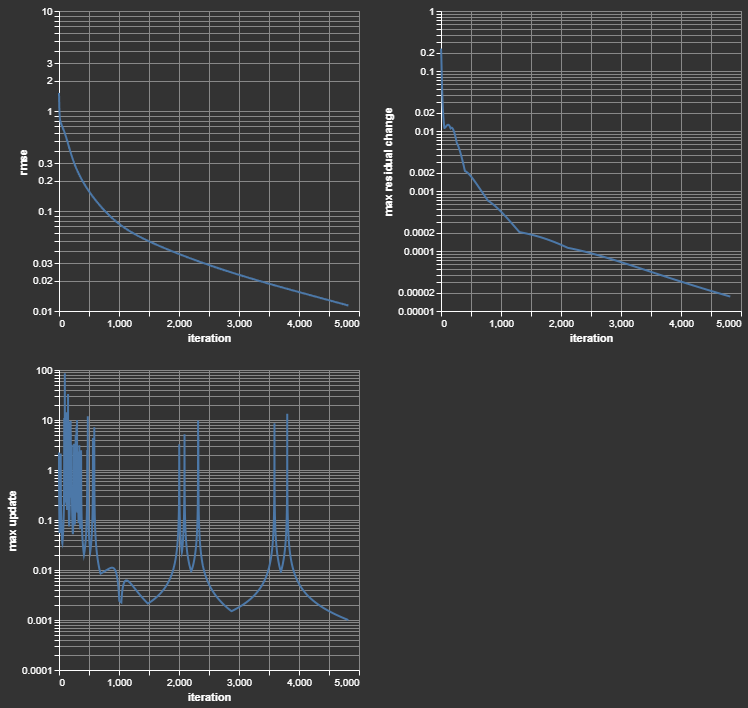

In [17]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

Top Left: This visual representation illustrates the logarithmic progression of the root mean squared error (RMSE) as the number of iterations increases. The steep decline in the curve indicates the algorithm's effectiveness in minimizing the RMSE throughout the iterations.  
  
Top Right: Here, we observe the logarithmic relationship between the maximum residual change and the number of iterations. The diminishing trend signifies a reduction in the disparities between predicted and actual values as the algorithm advances.   
  
Bottom Left: This plot showcases the logarithmic evolution of the maximum update value across iterations. The term "update" pertains to the adjustments made to the algorithm's parameters during optimization. The fluctuating pattern suggests varying magnitudes of updates as the algorithm explores the solution space.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [18]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

/tmp/ipykernel_2046/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


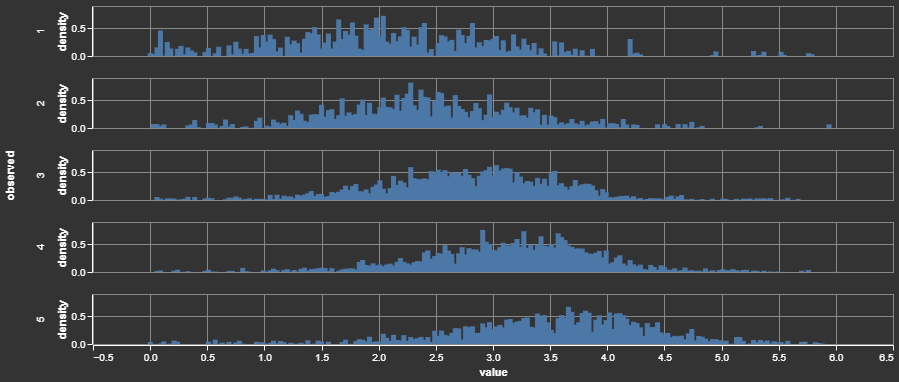

In [19]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

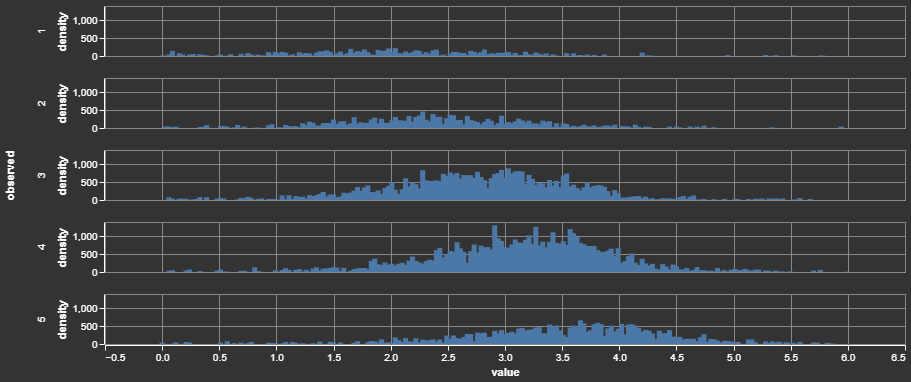

In [20]:
alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6],
    counts=True
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

The chart presents the model's predicted values for each film alongside the actual ratings provided by viewers, allowing for an evaluation of the model's accuracy and identification of any disparities between predicted and observed ratings. Each row illustrates the density distribution of the "fit" values corresponding to specific observed values. This visualization enables a thorough examination of how closely the predicted values match the observed ones across the entire dataset. While the close correspondence of distribution peaks with observed values suggests a generally strong fit, variations in spreads and potential bimodalities indicate areas for potential improvement or the presence of systematic biases or complexities in the relationship between fitted and observed values.  

By including counts=True in transform_density, the plot will illustrate the count of data points in each bin rather than the density. By comparing the plots with count parameter set to True and False, we can determine if the density plot closely resembles the count plot, indicating alignment between the model's predicted ratings and the observed ratings. Analyzing the plots, we observe a strong match between the density and count plots for observed rating levels 3, 4, and 5. However, the similarity diminishes for observed levels 1 and 2. What this means is that the model effectively predicts the densities of observed ratings 3, 4, and 5, while exhibiting less accuracy for levels 1 and 2 respectively

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [21]:
Rbig['rating', 601].sort_values(ascending=False).head(15)

movie id  movie title                                             
168       Monty Python and the Holy Grail (1974)                      5.0
132       Wizard of Oz, The (1939)                                    5.0
173       Princess Bride, The (1987)                                  5.0
228       Star Trek: The Wrath of Khan (1982)                         5.0
179       Clockwork Orange, A (1971)                                  5.0
181       Return of the Jedi (1983)                                   5.0
154       Monty Python's Life of Brian (1979)                         5.0
201       Evil Dead II (1987)                                         5.0
429       Day the Earth Stood Still, The (1951)                       5.0
763       Happy Gilmore (1996)                                        5.0
1084      Anne Frank Remembered (1995)                                5.0
921       Farewell My Concubine (1993)                                5.0
258       Contact (1997)                     

In [22]:
Rhatbig['rating', 601][Rhatbig['rating', 601] <= 5.0].sort_values(ascending=False).head(3)

movie id  movie title                           
1500      Santa with Muscles (1996)                 4.932997
168       Monty Python and the Holy Grail (1974)    4.223360
1467      Saint of Fort Washington, The (1993)      4.016834
Name: (rating, 601), dtype: float64

The top three films I would typically recommend to user id 601 are 'Santa with Muscles,' 'Monty Python and the Holy Grail,' and 'The Saint of Fort Washington.' However, since the user has already rated 'Monty Python and the Holy Grail' with a perfect score of 5.0, my revised recommendation for user id 601 would consist of 'Santa with Muscles' and 'The Saint of Fort Washington.' These films align closely with the user's positive ratings, especially considering that six out of their top fifteen films are from the 90s. Moreover, both films fall within the comedy/drama genre, which appears to be the user's preferred choice based on their viewing history.

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

$$
\begin{aligned}
\frac{\partial g}{\partial U} = 2 \lambda U\\
\frac{\partial g}{\partial U} = 2 \lambda V\\
U^{\text{new}} &= U + 2\alpha(\Gamma^TV - \lambda U)\\
V^{\text{new}} &= V + 2\alpha(\Gamma U - \lambda V)\\
\end{aligned}
$$

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [23]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - np.dot(V_, U_.T)

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    
    return U_ + alpha * 2 * (np.dot(np.nan_to_num(G_).T, V_) - lam * U_)

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    
    return V_ + alpha * 2 * (np.dot(np.nan_to_num(G_), U_) - lam * V_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [24]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [25]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [26]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [27]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

In [28]:
output_noreg['U']

k                     0         1         2         3         4         5   \
       user id                                                               
rating 1        0.771700  0.459470  0.889535  0.989491  0.535343  1.288662   
       85       0.675453  0.510901  0.868865  0.030736  0.352355  0.289211   
       269     -0.230475  0.310567 -0.065286 -0.307777  1.156409  0.212416   
       271      0.458771  0.156335  0.108619  0.055383  0.595110  0.528623   
       301      0.841403  0.897215  0.273605  0.553028 -0.028468  0.384083   
       312      0.165091  0.347064  0.497718  0.358326  0.199411  0.341391   
       328      0.216844  0.856807  0.558425  0.128498 -0.120171  1.089491   
       339      0.418317  0.651152  0.277278  0.601125  0.278812  0.861285   
       389      0.598640  0.756003 -0.063361  0.369019  0.633321  0.722122   
       650      0.170270  0.034316  0.544555  0.536635  0.042335  0.798994   
       716      0.483747 -0.014089  0.799126  0.652854  0.745676  0.959315   
       727      0.380607  0.525022  0.505563  0.637443  0.154541  0.927303   
       178      0.182380  0.518238  0.900213  0.144327  0.459577  0.313979   
       299      0.133780  0.317323 -0.068511  0.691206 -0.117040  0.506736   
       387      0.109831  0.416295  1.251280  0.186358  0.135068 -0.013157   
       883      0.575656  0.828594  0.612384  0.656016  0.120762  0.063865   

k                     6         7         8         9         10        11  \
       user id                                                               
rating 1        0.642739  0.640179 -0.093879  0.303733  0.292430  0.240707   
       85       1.184217 -0.071666  0.329377 -0.196768  0.803214  0.697368   
       269     -0.100243  0.311647  0.278866  0.626229  0.902029  0.725433   
       271      0.854349  1.117779  0.624403  0.626117 -0.249850  0.240747   
       301      0.453667  0.869981  0.704775  0.665187  1.167723  0.737707   
       312      0.462024  0.375567  1.227058  0.885302  0.645101  0.153560   
       328      1.130060 -0.017589  0.726639  0.730580  0.306952  0.081028   
       339      0.183968  0.450073  0.380363  0.650394  0.405748  0.177907   
       389      0.098456  0.617546  0.892734  0.212336  0.642819  0.026106   
       650      0.493349  0.730259  0.683755  0.054416 -0.092401  0.652415   
       716      0.441268 -0.054690  0.805414  0.767308  0.501407  0.420916   
       727      1.235406  0.681927 -0.128145  0.231576  0.549697  0.144493   
       178      0.462972  0.985387  0.545818  0.052659 -0.066669  0.493494   
       299      0.224043  0.652082  0.647168  0.432790  0.838844  0.223265   
       387     -0.404100  0.720023 -0.050460  0.369242  0.902631  0.539155   
       883      0.187436  0.069255  0.960907  0.050896  0.333349  0.006409   

k                     12        13        14        15        16        17  \
       user id                                                               
rating 1        0.286134  0.899088  0.175283  0.741566  0.113563  0.304571   
       85      -0.474173  0.577383  0.558268  0.678463  0.268724  0.892626   
       269      0.859257  0.376786  1.098631  0.845395  0.269221  1.082901   
       271      0.698632  0.170923  0.450504  0.478165  0.559304  0.507185   
       301     -0.025928  0.310087  0.825091 -0.124262  0.822346  0.243532   
       312      0.413042  0.498844  0.257519  1.081103  1.127889  0.151706   
       328      0.146868 -0.002753  0.969202  0.342581  0.384662  0.347829   
       339      0.216469  0.444497  0.687859  0.515373  0.623148  0.800105   
       389      0.433164  0.236521  0.895112  1.184865 -0.051916  0.293410   
       650      0.657175  0.726264  0.470095 -0.018073  0.350111  1.039753   
       716      0.619012  1.070350  0.461712  0.647643  0.753343  0.142998   
       727      0.383513  0.408227 -0.623056 -0.120828  0.418154  0.697507   
       178      1.107137 -0.106747  0.362182  0.822457  0.751312 -0.219247   
       299      0.74

In [29]:
output_reg['U']

k                     0         1         2         3         4         5   \
       user id                                                               
rating 1        0.510037  0.561486  0.652797  0.469687  0.403790  0.579236   
       85       0.475396  0.330886  0.354994  0.417334  0.397964  0.385808   
       269      0.473984 -0.119006 -0.052001  0.578960  0.567512  0.209886   
       271      0.473874  0.443689  0.564725  0.486654  0.431573  0.532576   
       301      0.489229  0.347842  0.428823  0.480176  0.466176  0.466760   
       312      0.459516  0.271405  0.375992  0.492005  0.450072  0.424040   
       328      0.424579  0.340125  0.426781  0.425225  0.392166  0.435768   
       339      0.506060  0.315338  0.414517  0.534356  0.494539  0.469789   
       389      0.462702  0.137843  0.238208  0.542217  0.487974  0.359103   
       650      0.430804  0.360988  0.432487  0.415133  0.387684  0.434728   
       716      0.529610  0.427197  0.534173  0.535165  0.471075  0.532192   
       727      0.387684  0.563752  0.623509  0.297846  0.270476  0.506360   
       178      0.387674  0.484951  0.645078  0.426427  0.348294  0.553388   
       299      0.352848  0.286571  0.401738  0.401479  0.354108  0.405420   
       387      0.282244  0.147167  0.248322  0.359937  0.316180  0.293907   
       883      0.384384  0.221501  0.300607  0.407269  0.365486  0.352599   

k                     6         7         8         9         10        11  \
       user id                                                               
rating 1        0.468741  0.380841  0.344847  0.436396  0.430578  0.440580   
       85       0.327970  0.380368  0.354490  0.415786  0.301018  0.326589   
       269      0.355465  0.487868  0.767792  0.536442  0.301058  0.268958   
       271      0.429307  0.382700  0.417181  0.430148  0.439751  0.393816   
       301      0.402183  0.408296  0.451101  0.456780  0.393266  0.361356   
       312      0.386272  0.396384  0.487405  0.447456  0.383841  0.349060   
       328      0.380955  0.349916  0.391594  0.401373  0.361584  0.339058   
       339      0.442398  0.436364  0.536641  0.490546  0.415552  0.383923   
       389      0.417054  0.427451  0.616301  0.488276  0.364025  0.341182   
       650      0.366755  0.349623  0.367298  0.390596  0.351265  0.334072   
       716      0.465493  0.428024  0.473801  0.487786  0.439181  0.427646   
       727      0.357035  0.260664  0.144995  0.299936  0.337876  0.353785   
       178      0.446040  0.297543  0.344600  0.357871  0.447313  0.392337   
       299      0.366494  0.303787  0.396230  0.351452  0.356003  0.306857   
       387      0.318511  0.259926  0.406265  0.305271  0.288149  0.242340   
       883      0.379653  0.326673  0.430633  0.390906  0.307226  0.320418   

k                     12        13        14        15        16        17  \
       user id                                                               
rating 1        0.524145  0.382800  0.395278  0.526836  0.412862  0.396698   
       85       0.423259  0.385321  0.349814  0.450602  0.352762  0.226854   
       269      0.443742  0.653541  0.432367  0.509778  0.590666  0.229060   
       271      0.492547  0.430353  0.382807  0.524407  0.449698  0.364506   
       301      0.471041  0.449892  0.391891  0.496928  0.445864  0.308234   
       312      0.459069  0.470506  0.384345  0.490328  0.461804  0.308740   
       328      0.428327  0.385861  0.347894  0.441384  0.396040  0.309263   
       339      0.509328  0.511779  0.422751  0.542168  0.510898  0.350803   
       389      0.481182  0.554643  0.418346  0.510993  0.542220  0.329556   
       650      0.423251  0.373988  0.338700  0.445496  0.378795  0.290539   
       716      0.541483  0.485192  0.431974  0.560186  0.492855  0.383542   
       727      0.378698  0.190169  0.270730  0.366068  0.229856  0.304206   
       178      0.458574  0.345669  0.338375  0.459629  0.410701  0.421280   
       299      0.39

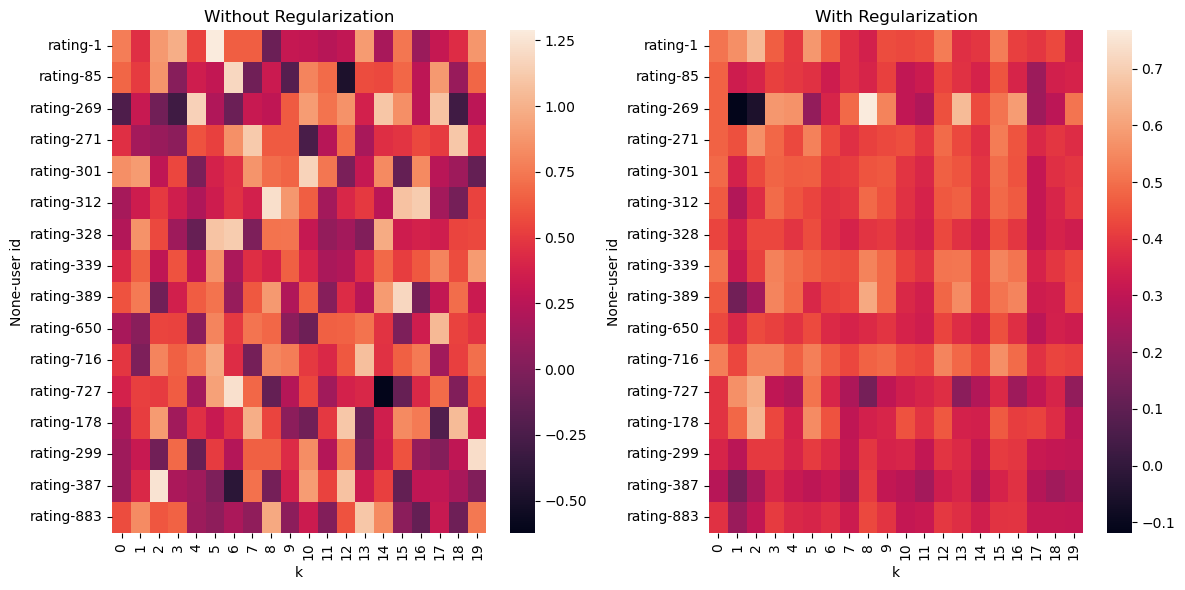

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 

sns.heatmap(output_noreg['U'], ax=axs[0])
axs[0].set_title('Without Regularization')

sns.heatmap(output_reg['U'], ax=axs[1])
axs[1].set_title('With Regularization')

plt.tight_layout() 
plt.show()

**Without Regularization (Left Heatmap)**: The heatmap shows the user matrix estimated without regularization. Each row represents a user, and each column represents a latent feature. The colors indicate the values of the latent features for each user. Without regularization, the values tend to be more spread out and vary widely across users and features.  
  
**With Regularization (Right Heatmap)**: The heatmap shows the user matrix estimated with regularization. Similar to the previous heatmap, each row represents a user, and each column represents a latent feature. However, with regularization, we observe more uniformity in the values across users and features. The values appear to be more concentrated and less spread out compared to the non-regularized matrix.  
  
**In relation to the concept of regularization**:  
Regularization introduces penalties to the model to prevent overfitting and reduce the complexity of the estimated parameters. The regularization term encourages the model to learn simpler and more generalizable patterns from the data, which can improve the model's performance on unseen data. Meaning that the observed differences in patterns do align with the concept of regularization.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

Shown below, when holding $K$ constant $(K = 65)$, smaller values of $\lambda$ have lower values for RMSE as the iterations increase. This can be explained by the fact that when $\lambda$ is small, the regularization penalty is weak, allowing the model to fit the training data more closely. As a result, the training error decreases, potentially leading to a lower RMSE.

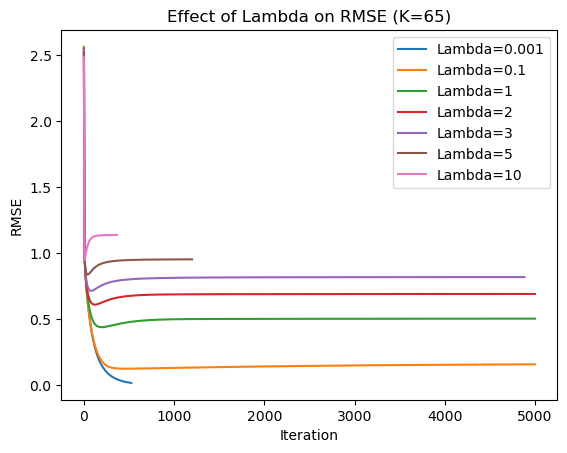

In [31]:
lambda_values = [0.001,0.1,1,2,3,5,10]
results_lambda = {}

for lam in lambda_values:
    np.random.seed(134)
    output_lambda = compute_UV_reg(Rsmall, K=65, lam=lam, alpha=0.001)
    results_lambda[lam] = output_lambda['rmse']

# Visualize RMSE for different lambda values
for lam, rmse_data in results_lambda.items():
    plt.plot(rmse_data['iteration'], np.sqrt(rmse_data['rmse']), label=f'Lambda={lam}')

plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Effect of Lambda on RMSE (K=65)')
plt.legend()
plt.show()

Then when holding $\lambda$ constant $(\lambda = 0.01)$, larger values of $K$ appear to decrease the RMSE. This can be attributed to the fact that with a larger $K$, each fold in our cross-validation represents a smaller fraction of the dataset, and the model is trained on a larger portion of the data. As a result, the model may capture more information from the training data and generalize better to unseen data, leading to lower RMSE values.

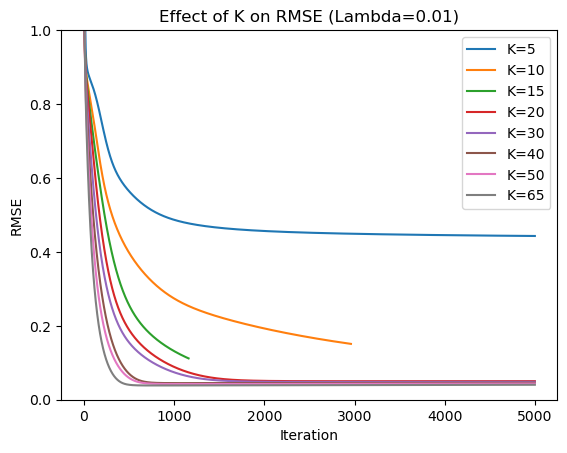

In [32]:
K_values = [5,10,15,20,30,40,50,65]
results_K = {}

for k in K_values:
    np.random.seed(134)
    output_K = compute_UV_reg(Rsmall, K=k, lam=0.01, alpha=0.001)
    results_K[k] = output_K['rmse']

# Visualize RMSE for different K values
for k, rmse_data in results_K.items():
    plt.plot(rmse_data['iteration'], np.sqrt(rmse_data['rmse']), label=f'K={k}')

plt.ylim(0, 1.0)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Effect of K on RMSE (Lambda=0.01)')
plt.legend()
plt.show()

To select an optimal $K$ and $\lambda$ value, we can systematically assess a wide range of values for both parameters and evaluate their performance using a common metric, such as RMSE. Upon conducting this analysis and applying UV decomposition with regularization, it is evident that $K = 65$ and $\lambda = 0.01$ are the optimal values for our dataset.

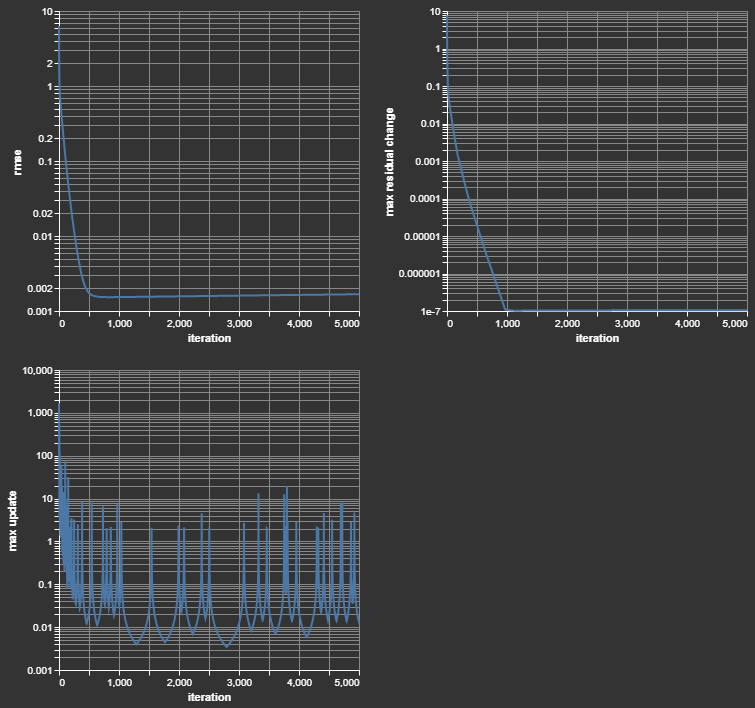

In [33]:
import altair as alt

opt = compute_UV_reg(Rsmall, K = 65, lam = 0.01, alpha = 0.001)

logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(opt['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(opt['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(opt['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

In assessing the clustering performance, several metrics can be utilized without relying on true labels. The three metrics employed in this analysis are the Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Index.

**Silhouette Score** measures the cohesion and separation of clusters, offering insight into how well each data point fits within its cluster compared to others. It operates independently of true labels, making it suitable for unsupervised learning tasks like clustering.

**Davies-Bouldin Index** computes the average similarity between each cluster and its most similar cluster. Lower values indicate better clustering, emphasizing both intra-cluster cohesion and inter-cluster separation. This metric, like the Silhouette Score, doesn't rely on true labels, enhancing its applicability in unsupervised scenarios.

**Calinski-Harabasz Index** calculates the ratio of dispersion between and within clusters, aiding in the assessment of cluster compactness and separation. Higher values suggest denser and more well-separated clusters, making it a valuable tool in evaluating clustering quality. As with the other metrics, the Calinski-Harabasz Index doesn't necessitate true labels.

In this specific analysis, K-means clustering outperforms hierarchical clustering across all three metrics. However, the choice of metric should also consider additional factors such as interpretability, computational efficiency, and the nature of the dataset. While K-means may excel in these metrics, hierarchical clustering might offer more intuitive cluster structures in certain contexts.

Interpretation of each metric within the context of the problem is crucial. For instance, a high Silhouette Score implies that the clusters are well-separated and internally cohesive, indicating distinct user and movie groupings. A low Davies-Bouldin Index signifies that clusters are both internally compact and well-separated, reinforcing the notion of clear cluster boundaries. Meanwhile, a high Calinski-Harabasz Index suggests dense, well-defined clusters with minimal overlap, reinforcing the effectiveness of the clustering algorithm in partitioning the data.

In [34]:
np.random.seed(134) # set seed for tests

ratings_stacked = pd.read_pickle('data/ratings_stacked.pkl')
users_with_less_na = ratings_stacked.isna().sum(axis=1) < 134
filtered_ratings = ratings_stacked[users_with_less_na]
filtered_ratings.reset_index(inplace =True)
filtered_ratings_134_234 = filtered_ratings[(filtered_ratings['movie id'] >= 134) &  (filtered_ratings['movie id'] <= 234)]
pivot_filtered_ratings_134_234 = filtered_ratings_134_234.pivot(index=['movie id', 'movie title'], columns = 'user id')
Rmedium = pd.concat([Rsmall, pivot_filtered_ratings_134_234])

In [35]:
output_best = compute_UV_reg(Rmedium, K=65, lam=0.01, alpha=0.001)  # Using parameters from the 'best' model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

U= output_best['U']
V = output_best['V']

scaler_U = StandardScaler()
U_std = scaler_U.fit_transform(U)

scaler_V = StandardScaler()

V_std = scaler_V.fit_transform(V)

UVstd = np.concatenate([U_std, V_std], axis=0)

In [36]:
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical.fit_predict(UVstd)

In [37]:
kmeans = KMeans(n_clusters=5, random_state=134)
kmeans_labels = kmeans.fit_predict(UVstd)

In [38]:
silhouette_hierarchical = silhouette_score(UVstd, hierarchical_labels)
silhouette_kmeans = silhouette_score(UVstd, kmeans_labels)

In [39]:
davies_bouldin_hierarchical = davies_bouldin_score(UVstd, hierarchical_labels)
davies_bouldin_kmeans = davies_bouldin_score(UVstd, kmeans_labels)

In [40]:
calinski_harabasz_hierarchical = calinski_harabasz_score(UVstd, hierarchical_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(UVstd, kmeans_labels)

In [41]:
print("Silhouette Score - Hierarchical:", silhouette_hierarchical, "| K-means:", silhouette_kmeans)
print("Davies-Bouldin Score - Hierarchical:", davies_bouldin_hierarchical, "| K-means:", davies_bouldin_kmeans)
print("Calinski-Harabasz Index - Hierarchical:", calinski_harabasz_hierarchical, "| K-means:", calinski_harabasz_kmeans)

Silhouette Score - Hierarchical: 0.03040510918712939 | K-means: 0.03437086928705028
Davies-Bouldin Score - Hierarchical: 5.230316627661305 | K-means: 4.8334559911201636
Calinski-Harabasz Index - Hierarchical: 59.91484609488468 | K-means: 65.31703520003762


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [42]:
# install umap
# !pip install umap-learn

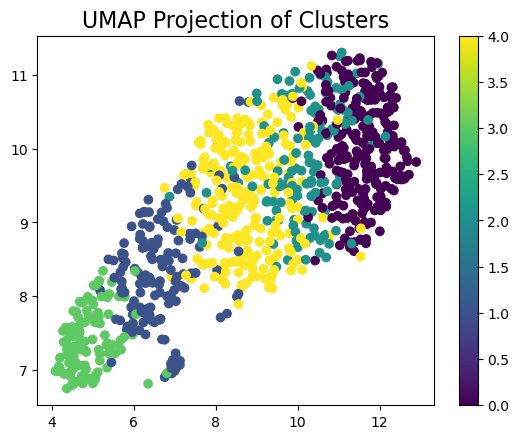

In [43]:
import umap

# Fit UMAP on the concatenated UVstd matrix
umap_transformer = umap.UMAP()
umap_embeddings = umap_transformer.fit_transform(UVstd)

# Create a scatter plot with UMAP embeddings and cluster labels
import matplotlib.pyplot as plt

scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=kmeans_labels, cmap="viridis")
plt.colorbar(scatter)
plt.title("UMAP Projection of Clusters", fontsize=16)
plt.show()

Based on the UMAP projection visualization, the clusters obtained from the K-means clustering method appear to be reasonably consistent with the underlying structure of the data.

In the UMAP plot, we can observe the following:  
  
**Distinct Cluster Separation**: The different clusters are generally well-separated in the UMAP projection, with points belonging to the same cluster forming distinct groups or regions. This separation suggests that the K-means clustering algorithm was able to identify meaningful clusters within the data.  
  
**Cluster Shapes and Densities**: The clusters exhibit varying shapes and densities in the UMAP projection. Some clusters appear more compact and dense (e.g., the yellow and purple clusters), while others are more spread out or elongated (e.g., the green and blue clusters). This variation in cluster shapes and densities can be attributed to the inherent structure of the data and the way the K-means algorithm partitioned the data points.  
  
**Cluster Boundaries**: While the clusters are relatively well-separated, there are some regions where the boundaries between clusters are not entirely clear-cut. This overlap or blurring of boundaries is expected, as real-world data often exhibits some degree of ambiguity or continuity between groups or patterns.  
  
**Potential Subclusters**: Within some of the larger clusters, such as the green and blue clusters, there appear to be smaller subgroups or potential subclusters. This observation suggests that there may be further structure or heterogeneity within these larger clusters that could be explored or accounted for in future analyses.  
  
Overall, the UMAP projection of the clusters obtained from the K-means method shows a reasonable level of consistency and alignment with the underlying structure of the data. The distinct separation of clusters, while allowing for some overlap and potential subclusters, indicates that the K-means algorithm was able to capture meaningful patterns and groupings within the data.  
  
It is important to note, however, that the interpretation of clusters and their quality should not solely rely on visual inspections but should also consider the quantitative evaluation metrics and domain knowledge. The UMAP projection provides a useful exploratory tool to visualize and gain insights into the clustering results, but it should be complemented with other analytical techniques and domain expertise for a comprehensive understanding of the data and the effectiveness of the clustering method.

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [44]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q2b results: All test cases passed!

    q2c results: All test cases passed!
